***RTSA Version 3***: Optimization, TipLets & WristLets Integration, Documentation

Installation

- Visual Studio Code


# **A. Setup & Modules**

### **Debug Mode**

In [1]:
# debug = True
debug = False

In [2]:
if debug: 
    # choose test image
    test_name = 'desk'
    # test_name = 'desk' # options: desk, guy, hand, backpack
    # test_name = 'hand' # options: desk, guy, hand, backpack

### **Imports**

In [3]:
import cv2
import numpy as np 
import torch
import mediapipe as mp
import matplotlib.pyplot as plt
import dearpygui.dearpygui as dpg
from scipy import ndimage
import time
import requests
from io import BytesIO
import re
import json
import onnxruntime as ort

### **Setup**

In [4]:
# viz_res = [640, 480]
viz_res = tuple([400, 300])
# window_size = [1400, 800]
window_size = [1400, 1100]

### **A0. Utils**

In [5]:
def imdpg2(img):
    return img.astype(np.float32)/255

In [6]:
def batch_imdpg2(imgs):
    return imgs.astype(np.float32)/255

# to use it, add the following lines of code @ DPG main loop, "Push Frames" section:
    # img_, edge_, seg_overlay_, masked_edge_, virtual_fov_, hand_tracking_, ofa_ = batch_imdpg2(np.stack((img, edge, seg_overlay, masked_edge[...,:3], virtual_fov, hand_tracking, ofa)))
    # dpg.set_value("original",      img_)
    # dpg.set_value("edge",          edge_) 
    # dpg.set_value("segmentation",  seg_overlay_)
    # dpg.set_value("masked_edge",   masked_edge_)
    # dpg.set_value("virtual_fov",   virtual_fov_)
    # dpg.set_value("hand_tracking", hand_tracking_)
    # # dpg.set_value("tiplets",       tiplets_)
    # dpg.set_value("ofa",           ofa_)

In [7]:
def rgba(img, mask=None):
    if mask is None: mask = np.zeros(img.shape[:2])+255 # white mask
    rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA) # convert to rgba
    rgba[:, :, 3] = np.interp(mask, (0, mask.max()), (0,255)) # rgba[:, :, 3] = mask # set alpha channel
    return rgba

In [8]:
def blend(rgba): # blend w/ zero brightness background
    alpha = np.interp(cv2.cvtColor(rgba[:,:,3], cv2.COLOR_GRAY2RGB), (0,255), (0,1))
    return (rgba[:,:,:3]*alpha).astype(np.uint8)

In [9]:
def blendtwo(rgba, rgb):
    alpha = (rgba[:,:,3].astype(np.float32)/255)[:,:,None] # add dummy axis @ dim=3
    return (rgba[:,:,:3]*alpha + rgb*(1-alpha)).astype(np.uint8)
# Study Reference: https://note.nkmk.me/en/python-opencv-numpy-alpha-blend-mask/

# due to notebook's order, run test case after spinning up Section A 
# plt.imshow(blendtwo(rgba(edge, seg_mask), img))

In [10]:
def blendtwo2(rgba, rgb):
    alpha = (rgba[...,3].astype(np.float32)/255)[...,None] # add dummy axis @ dim=3
    return (rgba[...,:3]*alpha + rgb*(1-alpha)).astype(np.uint8)

In [11]:
# addWeighted seems to only support **scalar** alpha values. let's fall back to blendtwo2.
def blendtwo3(rgba, rgb):
    alpha = rgba[...,3].astype(np.float32)/255; i_alpha = 1 - alpha
    return cv2.addWeighted(rgb[...,:3], alpha, rgba, i_alpha, 0)

### **A1. Input Camera Stream**

Selects a webcam connected to the PC. If multiple webcams are present, try `cv2.VideoCapture(1, 2, 3,...)` until the desired one is connected. 

(Note that it is possible to choose a video file with `cv2.VideoCapture('video_file.mp4')` for testing/debugging.)

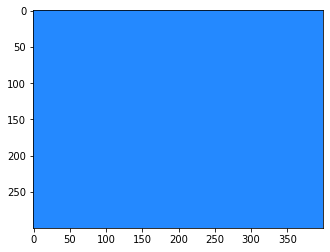

In [12]:
if debug: 
    img_raw = cv2.cvtColor(cv2.imread('./test_images/test_{}.jpg'.format(test_name)), cv2.COLOR_BGR2RGB)
else:
    cam = cv2.VideoCapture(0)
    _, img_raw = cam.read()

img = cv2.resize(img_raw, viz_res, interpolation=cv2.INTER_AREA)
img_rgba = rgba(img)
plt.imshow(img)

### **A2. Edge Detection**

#### **A2-1.** **Canny Edge Detection**

In [13]:
def canny(img, threshold_1=70, threshold_2=70):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(gray, 70, 70)
    return cv2.cvtColor(edge, cv2.COLOR_GRAY2RGB)

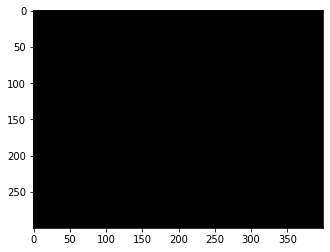

In [14]:
# tests
edge = canny(img)
plt.imshow(edge); plt.show()

# Parameter Exploration
# plt.imshow(canny(img, 60, 120)); plt.show()
# plt.imshow(canny(img, 100, 200)); plt.show()
# plt.imshow(canny(img, 200, 400)); plt.show()

#### **A2-2.** **Deep Edge Detection** (PiDiNet)

Commented out in favor of ONNX to save memory and improve loading time. 

In [15]:
# image preprocessing
import torchvision.transforms as transforms
prepare = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [16]:
# # imports
# from pidinet import models
# from pidinet.models.convert_pidinet import convert_pidinet
# from pidinet.utils import *
# import torchvision
# import torch.nn as nn

# # args
# class Args():
#     def __init__(self):
#         # dynamic (likely to change)
#         self.model = 'pidinet_small_converted'; self.evaluate_converted = True # refer to paper and source code
#         self.evaluate = './pidinet/trained_models/table5_pidinet-small.pth'
#         self.config = 'carv4' # model configurations
#         # static (unlikely to change)
#         self.sa = True; self.dil = True # use attention and dilation in diffnet respectively
#         self.use_cuda = torch.cuda.is_available()
#         # unused / dummy
#         self.save_dir = './pidinet/trained_models/'

# args = Args()

# # model
# model = getattr(models, args.model)(args)
# model = nn.DataParallel(model)
# checkpoint = load_checkpoint(args, running_file = None)
# if args.evaluate_converted: 
#     model.load_state_dict(convert_pidinet(checkpoint['state_dict'], args.config)) # assumes CUDA
# else: 
#     model.load_state_dict(checkpoint['state_dict'])
# if args.use_cuda: model = torch.nn.DataParallel(model).cuda()
# model.eval(); torch.set_grad_enabled(False) # sets the grad mode forever. source: https://discuss.pytorch.org/t/difference-between-set-grad-enabled-false-and-no-grad/72038

# # results = model(prepare(img))
# # result = torch.squeeze(results[-1]).cpu().numpy()

In [17]:
# def pidinet(img):
#     return torch.squeeze(model(prepare(img))[-1]).cpu().numpy()

# # test
# edge = (pidinet(img)*255).astype(np.uint8)
# plt.imshow(edge)

#### A2-3. **PiDiNet via ONNX**

Conclusions (7/28/2022):
- slower than expected. only option left now is TensorRT + INT8 quantization, pruning, [ONNX profiling](https://linuxtut.com/en/659b99396e63e0378f78/)
- There may be more options than what I am aware of.
  - Neural Magic?
  - Refer to [Hacker News thread](https://news.ycombinator.com/item?id=28484373) and tap into collective intelligence. 
    - So what are the best practices for CPU / GPU **inference**?
      - If CPU can be easily (within my skill / scope level) optimized, then CPU is honestly preferable.   
      But if GPU is much faster (or can easily be utilized w/ async using ONNX), then definitely GPU. 

In [18]:
ort_sess = ort.InferenceSession('PiDiNet_Tiny_1_simple_half.onnx', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

def pidinet_onnx(img):
    outputs = ort_sess.run(None, {'modelInput': prepare(img).numpy()})
    return outputs[-1].squeeze()

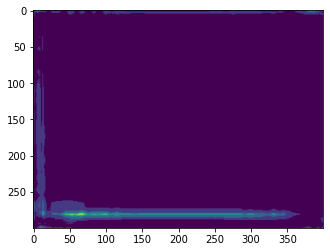

In [19]:
# test
plt.imshow(pidinet_onnx(img))

In [20]:
# %timeit [ort_sess.run(None, {'modelInput': prepare(img).numpy()}) for i in range(1000)]

Benchmark results (Tiny, FP16) (local): 11 ms

### **A3. Semantic Segmentation (Yolact Edge)**

[Also available as ONNX](https://github.com/PINTO0309/PINTO_model_zoo/tree/main/221_YOLACT-PyTorch). If TensorRT local runtime environment setup is feasible (not feeling comfortable with/ WSL2 + Nvidia-Docker solution due to future requirement for Bluetooth connections), then let's apply optimization techniques to this and move away from Yolact Edge.

In [21]:
# setup
from eval import *
parse_args(["--config=yolact_edge_config", "--calib_images=../calib_images"])
from eval import args

# settings
args.trained_model = "./weights/yolact_edge_54_800000.pth"
torch.set_default_tensor_type('torch.cuda.FloatTensor')
args.score_threshold = 0.5 # 0.3 # 0.15 # THRESHOLD # DEBUG # 중요!
args.top_k = 15

# initialize the network, load a pre-trained model.
net = Yolact(training=False)
net.load_weights(args.trained_model, args=args)
net.eval()
torch.set_grad_enabled(False)

# settings 2
net.detect.use_fast_nms = args.fast_nms
cfg.mask_proto_debug = args.mask_proto_debug # ?
extras = {"backbone": "full", "interrupt": False, "keep_statistics": False,  "moving_statistics": None}

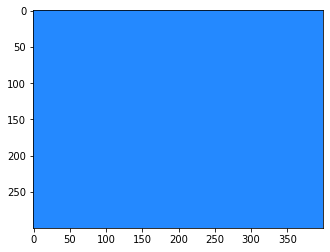

In [22]:
# frame preparation
frame = torch.from_numpy(img).cuda().float(); batch = FastBaseTransform()(frame.unsqueeze(0))
blank = torch.from_numpy(np.zeros(shape=img.shape)).cuda().float()

# segmentation
preds = net(batch, extras=extras)["pred_outs"]
preds2 = net(batch, extras=extras)["pred_outs"]
preds3 = net(batch, extras=extras)["pred_outs"]

plt.imshow(prep_display(preds, frame, None, None, False))

In [23]:
# print(preds[0]['box'])

In [24]:
# print(len(preds))

In [25]:
def binary_mask(dets_out, img): 
    img_gpu = img / 255.0
    h, w, _ = img.shape
    
    with timer.env('Postprocess'):
        t = postprocess(dets_out, w, h, visualize_lincomb = args.display_lincomb,
                                        crop_masks        = args.crop,
                                        score_threshold   = args.score_threshold)
        torch.cuda.synchronize()

    with timer.env('Copy'):
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][:args.top_k]
        # classes, scores, boxes = [x[:args.top_k].cpu().numpy() for x in t[:3]]
    
    try:
        masks = np.transpose(masks.cpu(), (1,2,0)).numpy()
        masks = masks.sum(axis=2)
        masks = np.interp(masks, (0, masks.max()), (0, 1)) # masks.min()
        return masks
    
    except Exception as e:
        print('binary_mask:', e)
        return np.zeros(img.shape[:2])

# plt.imshow(binary_mask(preds2, frame)); plt.show()

In [26]:
class_names = cfg.dataset.class_names

def analyze_segmentation(dets): # dets is preds[0]
    """returns the bounding box of classes of detected masks... but what about multi-instance cases?"""
    info = {}
    classes = dets['class']
    for i in range(len(classes)):
        info[class_names[classes[i]]] = dets['box'][i].cpu().numpy().astype(np.int32)

    return info # output format: [x1, y1, x2, y2]

#### **A3-1. Exploring `preds` Consumption**

In [27]:
def consume_preds(): pass # 필요 없어서 지움
# **결론**: `postprocess`를 지나는 순간 dets 소모.

#### **A3-2. `viz_and_mask()`**

In [28]:
def viz_and_mask(dets_out, img, h=None, w=None, undo_transform=False, class_color=True, mask_alpha=0.45):
    """Combination of original prep_display method & binary_mask method. Debug separately."""
    if undo_transform:
        img_numpy = undo_image_transformation(img, w, h)
        img_gpu = torch.Tensor(img_numpy).cuda()
    else:
        img_gpu = img / 255.0
        h, w, _ = img.shape
    
    with timer.env('Postprocess'):
        t = postprocess(dets_out, w, h, visualize_lincomb = args.display_lincomb,
                                        crop_masks        = args.crop,
                                        score_threshold   = args.score_threshold)
        torch.cuda.synchronize()

    with timer.env('Copy'):
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][:args.top_k]
            mask = t[3][:args.top_k] # 짜가 # maybe need to copy this via cpu.numpy method.
        classes, scores, boxes = [x[:args.top_k].cpu().numpy() for x in t[:3]]

        # from binary_mask()
        if mask.ndim >= 3:
            mask = np.transpose(masks.cpu(), (1,2,0)).numpy()
            mask = mask.sum(axis=2)
            mask = np.interp(mask, (0, mask.max()), (0, 1)) # masks.min()
        else: 
            mask = np.zeros(img.shape[:2])
        

    num_dets_to_consider = min(args.top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < args.score_threshold:
            num_dets_to_consider = j
            break
    
    if num_dets_to_consider == 0:
        # No detections found so just output the original image
        return (img_gpu * 255).byte().cpu().numpy(), np.zeros(img.shape[:2])

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)
        
        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice
    if args.display_masks and cfg.eval_mask_branch:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]
        
        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1
        
        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand
        
    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()
    
    if args.display_text or args.display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j)
            score = scores[j]

            if args.display_bboxes:
                cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)

            if args.display_text:
                _class = cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if args.display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.6
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
    

    try:
        return img_numpy, mask
    
    except Exception as e:
        print('viz_and_mask:', e)

# seg_overlay, seg_mask = viz_and_mask(preds3, frame)

#### **A3-3. Reload, One-Cycle for Acceleration @ Debug**

In [29]:
preds = net(batch, extras=extras)["pred_outs"]; dets = preds[0]

# TODO optimize : complexity of viz_and_mask
seg_overlay, seg_mask = viz_and_mask(preds, frame)
# plt.imshow(seg_overlay); plt.show(); plt.imshow(seg_mask)

### **A4. Edge Masking (Background Removal)**

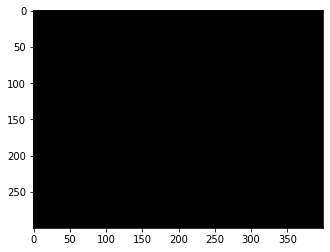

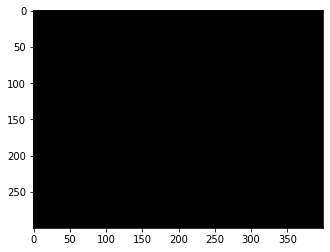

In [30]:
seg_rgba = rgba(edge, seg_mask)

# tests
# print(np.unique(seg_rgba))
plt.imshow(seg_rgba); plt.show()
plt.imshow(blend(rgba(edge, seg_mask))); plt.show()

# both methods work

#### **A4-1. Mask Dilation**

References:

- [Dilation - Wikipedia](https://en.wikipedia.org/wiki/Dilation_%28morphology%29)
- [Stackoverflow - NumPy Dilation (similar problem)](https://stackoverflow.com/questions/32706135/extend-numpy-mask-by-n-cells-to-the-right-for-each-bad-value-efficiently)
- [`scipy.ndimage.binary_dilation`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html)

In [31]:
d_r = 5 # dilation radius
stru = cv2.circle(np.zeros(shape=[d_r*2, d_r*2, 3]), (d_r, d_r), d_r, (255, 255, 255), -1)[:,:,0]
# plt.imshow(stru); plt.show()

# TODO this may promote brightness of all nonzero values to 1.
def dilate_mask(mask):
    return ndimage.binary_dilation(seg_mask, structure=stru, iterations=1, mask=None)

def dilate_mask2(mask):
    return ndimage.grey_dilation(seg_mask, footprint=stru)

In [32]:
def dilate_mask3(mask):
    return ndimage.grey_dilation(seg_mask, size=(d_r, d_r))

In [33]:
# test - original
masked_edge = blend(rgba(edge, seg_mask))
# plt.imshow(masked_edge)

In [34]:
# tests - dilated
# plt.imshow(seg_mask); plt.show()
dilated = dilate_mask(seg_mask)
# dilated2 = dilate_mask2(seg_mask)
# plt.imshow(dilated); plt.show()
# plt.imshow(dilated2); plt.show()
# plt.imshow(blend(rgba(edge, dilated))); plt.show();
# plt.imshow(blend(rgba(edge, dilated2)))

Canny Edge와 Deep (PiDiNet) Edge 둘다 실사용에서 비교해보자~ ✅

### **A5. Hand Tracking (MediaPipe Hand)**

In [35]:
# initialize model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
# process
mp_results = hands.process(img)

In [36]:
FINGERS = ['thumb', 'index', 'middle', 'ring', 'pinky']
MP_FINGERS = ['THUMB', 'INDEX_FINGER', 'MIDDLE_FINGER', 'RING_FINGER', 'PINKY']
MP_KEYS = mp_hands.HandLandmark
FINGER_COLORS = ([180, 229, 255], [128, 64, 128], [0, 204, 255], [48, 255, 48], [192, 101, 21])

def tip_info(mp_results, img): # hardcoded, naive.
    
    pos = {}; dir = {}

    # detected pose landmarks
    landmarks = mp_results.multi_hand_landmarks

    if landmarks: # i.e., if hands are detected 
        y_max, x_max = img.shape[:2]
        # NOTE: only the lastly (most recent) detected hand is used
        for hand in landmarks: 
            landmark = hand.landmark 
            # readable shortcuts
            thumb_tip  = landmark[MP_KEYS.THUMB_TIP];         thumb_dip  = landmark[MP_KEYS.THUMB_IP]
            index_tip  = landmark[MP_KEYS.INDEX_FINGER_TIP];  index_dip  = landmark[MP_KEYS.INDEX_FINGER_DIP]
            middle_tip = landmark[MP_KEYS.MIDDLE_FINGER_TIP]; middle_dip = landmark[MP_KEYS.MIDDLE_FINGER_DIP]
            ring_tip   = landmark[MP_KEYS.RING_FINGER_TIP];   ring_dip   = landmark[MP_KEYS.RING_FINGER_DIP]
            pinky_tip  = landmark[MP_KEYS.PINKY_TIP];         pinky_dip  = landmark[MP_KEYS.PINKY_DIP]
            
            # convert normalized coordinates (0-1) to pixel coordinates.
            pos['thumb']  = np.array((thumb_tip.x  * x_max, thumb_tip.y  * y_max), dtype=np.int32)
            pos['index']  = np.array((index_tip.x  * x_max, index_tip.y  * y_max), dtype=np.int32)
            pos['middle'] = np.array((middle_tip.x * x_max, middle_tip.y * y_max), dtype=np.int32)
            pos['ring']   = np.array((ring_tip.x   * x_max, ring_tip.y   * y_max), dtype=np.int32)
            pos['pinky']  = np.array((pinky_tip.x  * x_max, pinky_tip.y  * y_max), dtype=np.int32)
            
            # compute finger direction using the tip position and DIP (distal phalanx) position. 
            # NOTE: fingertip direction is based on pixel coordinates (i.e., [downwards y, rightwards x])
            # NOTE: This is wildly inaccurate in 3D. User is expected to keep hand planar to the camera. 
            #       A proper implementation based on 3D euler angles is needed for further improvements.
            dir['thumb']  = np.array((thumb_tip.x  - thumb_dip.x,  thumb_tip.y  - thumb_dip.y))
            dir['index']  = np.array((index_tip.x  - index_dip.x,  index_tip.y  - index_dip.y))
            dir['middle'] = np.array((middle_tip.x - middle_dip.x, middle_tip.y - middle_dip.y))
            dir['ring']   = np.array((ring_tip.x   - ring_dip.x,   ring_tip.y   - ring_dip.y))
            dir['pinky']  = np.array((pinky_tip.x  - pinky_dip.x,  pinky_tip.y  - pinky_dip.y))
            
            # normalize direction vectors
            for finger in FINGERS:
                dir[finger] /= np.linalg.norm(dir[finger])
            
    return pos, dir

tip_pos, tip_dir = tip_info(mp_results, img)

In [37]:
# initialize visualization
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [38]:
def visualize_hands(mp_results, img):
    img = img.copy()
    landmarks = mp_results.multi_hand_landmarks
    if landmarks:
        for landmark in landmarks:
            mp_drawing.draw_landmarks(
                img, landmark, mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
        # print(landmarks)
    return img

# plt.imshow(visualize_hands(mp_results, img))

In [39]:
# # 3d visualization (source: MediaPipe Documentation)
# if results.multi_hand_world_landmarks is not None:
#   for hand_world_landmarks in results.multi_hand_world_landmarks:
#     mp_drawing.plot_landmarks(
#       hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

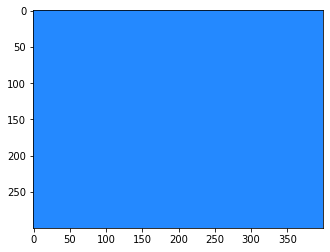

In [40]:
def visualize_tips(tip_pos, tip_dir=None, img=None):
    img = img.copy()
    r = 20
    for i, finger in enumerate(tip_pos):
        cv2.circle(img, tip_pos[finger], r, FINGER_COLORS[i], 1) # 2)
        # cv2.line(img, tip_pos[finger], (tip_pos[finger][0] + tip_dir[finger][0] * r, tip_pos[finger][1] + tip_dir[finger][1] * r), FINGER_COLORS[i], 1) # 2)
        cv2.line(img, tip_pos[finger], (tip_pos[finger]+tip_dir[finger]*r).astype(np.int32), FINGER_COLORS[i], 1) # 2)

    return img

plt.imshow(visualize_tips(*tip_info(mp_results, img), img)) # * unpacks

On Optimization:
To properly conduct vibratory tactile substitution experiments, real-time framerae is essential.

### **A6. TipLets Output Visualization**

In [41]:
def draw_tiplet(origin, magnitudes, img, custom_color=None): # mutable... probably # origin is upper-left. magnitudes is [] of floats (0-1) with length of 6.
    # img = img.copy()
    origin = origin.copy()
    
    rad = 10
    dia = rad*2
    m = 3 # margin
    origin += np.array([0, 0]) # adjustment

    # fill_color = (255,255,255)
    fill_color = [255,255,255]
    # outline_color = (0.5,0.5,0.5) # cv2 infers max threshold as 255 or 1.0. 
    # outline_color = [127,127,127]
    outline_color = [180,180,180]
    th = 2 # thickness

    if img.shape[2] == 4: # if img==RGBA
        fill_color.append(255)
        outline_color.append(255)

    # fill
    cv2.circle(img, origin+np.array([     0,         0]), int(magnitudes[0]*rad), fill_color, -1)
    cv2.circle(img, origin+np.array([ dia+m,         0]), int(magnitudes[1]*rad), fill_color, -1)
    cv2.circle(img, origin+np.array([     0,     dia+m]), int(magnitudes[2]*rad), fill_color, -1)
    cv2.circle(img, origin+np.array([ dia+m,     dia+m]), int(magnitudes[3]*rad), fill_color, -1)
    cv2.circle(img, origin+np.array([     0, (dia+m)*2]), int(magnitudes[4]*rad), fill_color, -1)
    cv2.circle(img, origin+np.array([ dia+m, (dia+m)*2]), int(magnitudes[5]*rad), fill_color, -1)

    # outline
    cv2.circle(img, origin+np.array([     0,         0]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([ dia+m,         0]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([     0,     dia+m]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([ dia+m,     dia+m]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([     0, (dia+m)*2]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([ dia+m, (dia+m)*2]), rad, outline_color, th)

    return img

# plt.imshow(draw_tiplet(origin=np.array([20, 20]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[100,100,3]))); plt.show()
# plt.imshow(draw_tiplet(origin=np.array([20, 20]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[100,100,4]))); plt.show()
# plt.imshow(draw_tiplet(origin=np.array([10, 10]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[67,44,3])))
# plt.imshow(draw_tiplet(origin=np.array([10, 10]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[67,44,3], dtype=np.uint8)))
# plt.imshow(draw_tiplet(origin=np.array([20, 20]), magnitudes=[1, 1, 1, 1, 1, 1], img=np.zeros(shape=img.shape)))

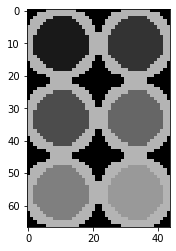

In [42]:
def draw_tiplet2(origin, magnitudes, img, custom_color=None): # mutable... probably # origin is upper-left. magnitudes is [] of floats (0-1) with length of 6.
    # img = img.copy()
    origin = origin.copy()
    
    rad = 10
    dia = rad*2
    m = 3 # margin
    origin += np.array([0, 0]) # adjustment

    if custom_color: fill_color = custom_color.copy()
    else:            fill_color = [255,255,255]
    # outline_color = (0.5,0.5,0.5) # cv2 infers max threshold as 255 or 1.0. 
    # outline_color = [127,127,127]
    outline_color = [180,180,180]
    # outline_color = [220,220,220]
    th = 2 # thickness


    if img.shape[2] == 4: # if img==RGBA
        # fill_color.append(255)
        outline_color.append(255)


    fill_color = np.array(fill_color, dtype=np.uint8)


    # fill
    cv2.circle(img, origin+np.array([     0,         0]), rad, (fill_color*magnitudes[0]).astype(np.uint8).tolist()+[255], -1)
    cv2.circle(img, origin+np.array([ dia+m,         0]), rad, (fill_color*magnitudes[1]).astype(np.uint8).tolist()+[255], -1)
    cv2.circle(img, origin+np.array([     0,     dia+m]), rad, (fill_color*magnitudes[2]).astype(np.uint8).tolist()+[255], -1)
    cv2.circle(img, origin+np.array([ dia+m,     dia+m]), rad, (fill_color*magnitudes[3]).astype(np.uint8).tolist()+[255], -1)
    cv2.circle(img, origin+np.array([     0, (dia+m)*2]), rad, (fill_color*magnitudes[4]).astype(np.uint8).tolist()+[255], -1)
    cv2.circle(img, origin+np.array([ dia+m, (dia+m)*2]), rad, (fill_color*magnitudes[5]).astype(np.uint8).tolist()+[255], -1)

    # outline
    cv2.circle(img, origin+np.array([     0,         0]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([ dia+m,         0]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([     0,     dia+m]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([ dia+m,     dia+m]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([     0, (dia+m)*2]), rad, outline_color, th)
    cv2.circle(img, origin+np.array([ dia+m, (dia+m)*2]), rad, outline_color, th)

    return img.astype(np.uint8)

# plt.imshow(draw_tiplet2(origin=np.array([20, 20]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[100,100,3]))); plt.show()
# plt.imshow(draw_tiplet2(origin=np.array([20, 20]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[100,100,4]))); plt.show()
plt.imshow(draw_tiplet2(origin=np.array([10, 10]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[67,44,3])))
# plt.imshow(draw_tiplet2(origin=np.array([20, 20]), magnitudes=[1, 1, 1, 1, 1, 1], img=np.zeros(shape=img.shape, dtype=np.uint8)))

In [43]:
tiplet_viz = draw_tiplet(origin=np.array([10, 10]), magnitudes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], img=np.zeros(shape=[67,44,3], dtype=np.uint8))

In [44]:
tiplet_viz.dtype

dtype('uint8')

#### A6-1. TipLets Overview Window

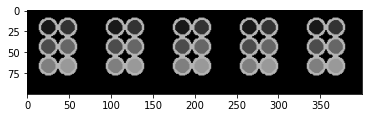

In [45]:
def draw_tiplet_outputs(outputs):
    img = np.zeros(shape=[100, 400, 3], dtype=np.uint8)
    origin = np.array([25, 20])
    spacing = np.array([80, 0])
    draw_tiplet2(origin,           outputs['thumb'],  img)
    draw_tiplet2(origin+spacing,   outputs['index'],  img)
    draw_tiplet2(origin+spacing*2, outputs['middle'], img)
    draw_tiplet2(origin+spacing*3, outputs['ring'],   img)
    draw_tiplet2(origin+spacing*4, outputs['little'], img)
    return img

outputs = {'thumb': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
           'index': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
           'middle': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
           'ring': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
           'little': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
plt.imshow(draw_tiplet_outputs(outputs))

#### A6-2. On-Screen Visualization

Drawn onto `virtual_fov` window.

In [46]:
# graphics utils

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

# Source:   https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python
# Source 2: https://www.adamsmith.haus/python/answers/how-to-get-the-angle-between-two-vectors-in-python
# Modified to add directionality for vector alignment.

def angle_between_2d(v1=(0,1), v2=(1,0)):
    
    u1 = v1 / np.linalg.norm(v1)
    u2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(u1, u2)

    angle = np.arccos(dot_product)*57.3 # in degrees
    
    if np.cross(u1, u2) < 0: return -angle
    else: return angle

# tests
# print(angle_between_2d(v1=(0.1,1), v2=(1,0)))
# print(angle_between_2d(v1=(0.1,-1), v2=(1,0)))
# print(angle_between_2d(v1=(0,1), v2=(1,0)))
# print(angle_between_2d(v1=(1,0), v2=(1,0)))

In [47]:
# Unit Canvas 크기:
# - shape=[67,44,4]가 현재 tiplets에 딱 맞는 사이즈지만 회전을 고려하면 80x80 필요. 
# - 만약 80x80이라면 origin을 무엇으로 잡을까? 
# - [10,10] + [(80-67), (80-44)]/2 = [16.5, 28] in (x, y) format. 
# - OpenCV circle은 round-down 하는 경향이 있기에 16.5 -> 16

# def draw_tiplet_at(values, center, direction, img, scale=0.5, custom_color=None): # center -> (y, x)
#     # unit canvas
#     canvas = np.zeros(shape=[80,80,4], dtype=np.uint8) # 
#     # draw
#     # draw_tiplet(np.array([28, 16]), values, canvas, custom_color=custom_color)
#     draw_tiplet2(np.array([28, 16]), values, canvas, custom_color=custom_color)
#     # rotate
#     angle = angle_between_2d(direction, np.array([0, -1])) # direction vector to rotation angle *with directionality*
#     M = cv2.getRotationMatrix2D((40,40), angle, scale)
#     # resize
#     canvas = cv2.warpAffine(canvas, M, canvas.shape[:2], flags=cv2.INTER_AREA)
#     # integrate
#     big_canvas = np.zeros(shape=(*img.shape[:2],4), dtype=np.uint8)
#     big_canvas[center[1]-40:center[1]+40, center[0]-40:center[0]+40] = canvas
#     # NOTE tip_info()가 (x,y) 식의 좌표를 줘서 약간 헷갈리는데, 바꾸는게 좋을지도. 생각해보자.

#     return blendtwo2(big_canvas, img)


def draw_tiplet_at2(values, center, direction, img, scale=0.5, custom_color=None): # center -> (y, x)
    # unit canvas
    canvas = np.zeros(shape=[80,80,3], dtype=np.uint8) # 
    # draw
    draw_tiplet2(np.array([28, 16]), values, canvas, custom_color=custom_color)
    # rotate
    angle = angle_between_2d(direction, np.array([0, -1])) # direction vector to rotation angle *w/ directionality*
    M = cv2.getRotationMatrix2D((40,40), angle, scale)
    # resize
    canvas = cv2.warpAffine(canvas, M, canvas.shape[:2], flags=cv2.INTER_AREA)
    # integration with output image is done @ visualize_tiplets2(), which calls this function.

    return canvas


# test
# plt.imshow(draw_tiplet_at([1,0.5,0.5,1,1,0.5], np.array([100,100]), np.array([0.5,0.5]), img, 0.5)); plt.show()
# plt.imshow(draw_tiplet_at([1,0.5,0.5,1,1,0.5], np.array([100,100]), np.array([0.5,0.5]), np.zeros(shape=img.shape), 0.5)); plt.show()
# plt.imshow(draw_tiplet_at([1,0.8,0.6,0.4,0.2,0], np.array([100,100]), np.array([1,0]), np.zeros(shape=img.shape), 0.5)); plt.show()
# plt.imshow(draw_tiplet_at([1,0.8,0.6,0.4,0.2,0], np.array([100,100]), np.array([0,1]), np.zeros(shape=img.shape), 0.5)); plt.show()
# plt.imshow(draw_tiplet_at([1,0.8,0.6,0.4,0.2,0], np.array([100,100]), np.array([-1,0]), np.zeros(shape=img.shape), 0.5)); plt.show()
# plt.imshow(draw_tiplet_at([1,0.8,0.6,0.4,0.2,0], np.array([100,100]), np.array([0,-1]), np.zeros(shape=img.shape), 0.5)); plt.show()

Note: `visualize_tiplets2` returns flawless results but is marginally slower (~5% framerate drop). `visualize_tiplets3` is faster but shows distortions on overlapped regions

In [48]:
# def visualize_tiplets(tip_pos, tip_dir, img):
#     for (i, finger) in enumerate(FINGERS):
#         img = draw_tiplet_at([1, 0.8, 0.6, 0.4, 0.2, 0], tip_pos[finger], tip_dir[finger], img, custom_color=FINGER_COLORS[i])
#     return img

def visualize_tiplets2(tip_pos, tip_dir, img):

    big_canvas = np.zeros(shape=img.shape, dtype=np.uint8) # shape=(*img.shape[:2],3) if input image is RGBA
    
    for (i, finger) in enumerate(FINGERS):
        center, direction = tip_pos[finger], tip_dir[finger]

        canvas = draw_tiplet_at2([1, 0.8, 0.6, 0.4, 0.2, 0], center, direction, img, custom_color=FINGER_COLORS[i])

        # big_canvas[center[1]-40:center[1]+40, center[0]-40:center[0]+40] += canvas
        nonzero=(big_canvas==0) # array of bool
        candidate = big_canvas.copy() 
        candidate[center[1]-40:center[1]+40, center[0]-40:center[0]+40] = canvas

        big_canvas[nonzero] = candidate[nonzero]

    return big_canvas


def visualize_tiplets3(tip_pos, tip_dir, img):

    big_canvas = np.zeros(shape=(*img.shape[:2],3), dtype=np.uint8)
    
    for (i, finger) in enumerate(FINGERS):
        center, direction = tip_pos[finger], tip_dir[finger]

        canvas = draw_tiplet_at2([1, 0.8, 0.6, 0.4, 0.2, 0], center, direction, img, custom_color=FINGER_COLORS[i])

        big_canvas[center[1]-40:center[1]+40, center[0]-40:center[0]+40] += canvas

        # basic idea: prevent overlaps by using indexing like visualize_tiplets2 but to canvas and not big_canvas TODO

    # return np.clip(big_canvas, a_max=255) ## uncomment in case of error / overflow 
    return big_canvas

# test
try: plt.imshow(visualize_tiplets3(*tip_info(mp_results, img), img)); plt.show()
except Exception as e: print(e)

'thumb'


In [49]:
# test with hand tracking
try:
    # tiplets
    plt.imshow(visualize_tiplets2(*tip_info(mp_results, img), img)); plt.show()
    plt.imshow(visualize_tiplets2(*tip_info(mp_results, img), img)); plt.show()
    plt.imshow(visualize_tiplets2(*tip_info(mp_results, img), np.zeros(shape=img.shape, dtype=np.uint8))); plt.show()

    # # fingertip, tiplets 둘다
    # plt.imshow(visualize_tiplets(*tip_info(mp_results, img), visualize_tips(*tip_info(mp_results, img), img))); plt.show()
    # plt.imshow(visualize_tiplets(*tip_info(mp_results, img), visualize_tips(*tip_info(mp_results, img), np.zeros(shape=img.shape))))

except Exception: 
    print('error: no hands detected (probably)')


error: no hands detected (probably)


### **A7. Natural Language Interactivity**

**Instructions**:

1. Open [the server](https://colab.research.google.com/drive/1HyD_N1ebXq6YCEvRykSOl1rt0h_dVZ9K?usp=sharing) and spin it up @ Google Colab.
    - The server runs an image & language processing model called OFA. Learn more ([GitHub]()), ([Paper]()) 
    - Make sure GPU instance is being used (Menu-Runtime-Change Runtime Type)
2. Copy the URL printed at the bottom of Colab notebook into the GUI
    - Alternatively, edit ngrok_url.txt in this directory. Make sure the address ends with / (slash)
    - The URL looks like this: http://9fb9-34-105-0-120.ngrok.io

#### **A7-1. Naive Search** 

In [50]:
# deprecated. refer to main_2.ipynb

#### **A7-2. OFA Inference via Colab**

In [51]:
# TODO code quality is really not good here 

In [52]:
url_file = open('./ngrok_url.txt', 'r+')

url = url_file.read()
if url[-1] != '/': url += '/'
print(url)

http://9fb9-34-105-0-120.ngrok.io/


**Connection Status Check**

In [53]:
def update_status(mode=''):
    ping = requests.get(url).text
    if ping == '{"hello":"world"}': 
        dpg.set_value('colab_status_text', 'Connected')
        dpg.configure_item('colab_status_text', color=[0,255,0])
    else:
        dpg.set_value('colab_status_text', 'Disconnected')
        dpg.configure_item('colab_status_text', color=[255,0,0])

In [54]:
# update_status()

**URL Management (via GUI)**

In [55]:
def update_url():
    
    new_url = dpg.get_value('url_input')
    if new_url[-1] != '/': new_url += '/'

    global url
    url = new_url

    url_file.seek(0)
    url_file.write(new_url)
    url_file.truncate()
    url_file.close()

    update_status()

**Interaction with OFA Server (on Google Colab)**

In [56]:
def call_ofa(input, route=''):

    _, buffer = cv2.imencode('.jpg', img)
    image_file = BytesIO(buffer)

    params = { 'instruction': input }
    # files = { 'file': open('./test_images/test_desk.jpg', 'rb') } # DEBUG
    files = { 'file': ('img.jpeg', image_file, 'image/jepg') }
    response = requests.post(url+route, params=params, files=files)

    # print(response.text) # DEBUG

    return response.text

In [57]:
# test
# call_ofa('a monitor')
# call_ofa('a screen')
# np.array(json.loads('[436.4898231564899,314.55455455455456,569.7430764097431,360.04004004004]'), dtype=np.int32)

In [58]:
# # bounding box visualization test
# [272, 196, 356, 225]
# ofa = cv2.rectangle(img.copy(), [272, 196], [356, 225], (0,0,255), 2)
# plt.imshow(ofa)

In [59]:
ofa = img.copy()

In [60]:
def parse_language(mode='test', test_input=''):

    if mode != 'test': input = dpg.get_value('language_input')
    if mode == 'test': input = test_input

    if dpg.get_value('ofa_task') == 'Object Finding':

        message = call_ofa(input, 'grounding') # img is global so no need to pass.

        if re.search('[a-zA-Z]', message): 
            print(message)
        else: # only numbers (i.e., no alphabet in return message)
            response = json.loads(message)
            print('response:', response)
            bbox = np.array(response, dtype=np.int32)
            print('detected a bounding box from msg:', bbox)
        
            global ofa
            try: 
                ofa = cv2.rectangle(img.copy(), [bbox[0], bbox[1]], [bbox[2], bbox[3]], (0,255,0), 2)
                # ofa = cv2.rectangle(img.copy(), a, (0,255,0), 2)
            except Exception as e: print('Error drawing bounding box:', e)

    if dpg.get_value('ofa_task') == 'Question Answering' or dpg.get_value('ofa_task') == 'Image Captioning':
        if dpg.get_value("ofa_task") == "Image Captioning": input = "What does the image describe?" # TODO better code

        message = call_ofa(input, 'answering') # img is global so no need to pass.

        # if re.search('[<,>]', message): # contains word 'ngrok'. probably an http error
            # print('error (probably):', message)
        # else: 
        response = json.loads(message)
        print('response:', response)

        
        try: 
            dpg.set_value('ofa_output', "Output: "+response)
        except Exception as e: print('Error setting OFA output text:', e)
        # TODO add back the regex search if empty-input VQA case (error detection false positive) successfully avoids it

In [61]:
# parse_language(mode='test', test_input='the apple logo')
# plt.imshow(ofa)

#### **A7-3. Zoom & Re-Center**

In [62]:
def zoom_image(img, factor, point=None): # point -> (y,x)
    # create a larger image. this will then be cropped into original image's size to create zoom effect.
    large = cv2.resize(img, [int(img.shape[1]*factor), int(img.shape[0]*factor)])
    center = (large.shape[0]/2, large.shape[1]/2)
    # without a specified zooming point, defaults to zooming about the center
    if point is None: upper_right = (int(center[0]-img.shape[0]/2), int(center[1]-img.shape[1]/2))
    else:             upper_right = (int(center[0]-img.shape[0]+point[0]), int(center[1]-img.shape[1]+point[1]))

    final_image = large[upper_right[0]:upper_right[0]+img.shape[0], upper_right[1]:upper_right[1]+img.shape[1]]    
    return final_image

In [63]:
def move_center(img, center): # center -> (y,x)
    # Translation distances in x and y axis

    x_trans = int(img.shape[0]//2-center[0])
    y_trans = int(img.shape[1]//2-center[1])

    # Pad and remove pixels from image to perform translation

    if x_trans > 0:
        im2 = np.pad(img, ((x_trans, 0), (0, 0), (0, 0)), mode='constant')
        im2 = im2[:img.shape[0]-x_trans, :]
    else:
        im2 = np.pad(img, ((0, -x_trans), (0, 0), (0, 0)), mode='constant')
        im2 = im2[-x_trans:, :, :]

    if y_trans > 0:
        im3 = np.pad(im2, ((0, 0), (y_trans, 0), (0, 0)), mode='constant')
        im3 = im3[:, :img.shape[0]-y_trans]

    else:
        im3 = np.pad(im2, ((0, 0), (0, -y_trans), (0, 0)), mode='constant')
        im3 = im3[:, -y_trans:]
    
    return im3

# NOTE Only works for 3-dimensional images (i.e., no grayscale). 
#      Delete the last (0,0) from pad_width argument for 2D images.

In [64]:
# test
# canvas = np.zeros((200, 200, 3), dtype=np.uint8)
# canvas = cv2.circle(canvas, (150, 150), 5, (255,0,0), 1)
# plt.imshow(canvas); plt.show(); # circle @ bottom-right
# plt.imshow(zoom_image(move_center(canvas, center=[150,150]), 1)) # circle @ center

## **A8. Object Tracking**

It would have been preferable to use [single object tracking](https://arxiv.org/ftp/arxiv/papers/2201/2201.13066.pdf) methods since it almost perfectly aligns with the purposes of this project. However, there isn't a well-implemented real-time single object tracking solution available for public. So the plan is to first use multi-object tracking (SORT), and then seek improvements if needed after conducting experiments.

#### A8-0. Yolov7

SORT family of multi-object tracking (MOT) algorithms require a object detection backbone. [Source](https://github.com/ibaiGorordo/ONNX-YOLOv7-Object-Detection)

In [65]:
from YOLOv7 import YOLOv7

model_path = './YOLOv7/models/yolov7-tiny_256x320.onnx'
yolov7_detector = YOLOv7(model_path, conf_thres=0.3, iou_thres=0.5)

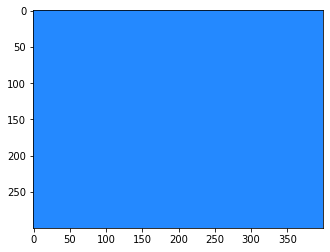

In [66]:
boxes, scores, class_ids = yolov7_detector(img)

yolo_viz = yolov7_detector.draw_detections(img)
plt.imshow(yolo_viz)

#### A8-1. SORT

SORT algorithm determines the continuity of previously & currently seen objects by applying a kalman filter. [More about SORT](). [Source](https://github.com/abewley/sort)

In [67]:
from sort import *

#create instance of SORT
mot_tracker = Sort() 

In [68]:
# get detections
dets = np.concatenate((boxes, scores[:,np.newaxis]),axis=1)

# update SORT
track_bbs_ids = mot_tracker.update(dets)
# dets -> a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]

# track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

In [69]:
track_bbs_ids.astype(np.int32)

array([], shape=(0, 5), dtype=int32)

#### A8-2. Deep SORT

Deep SORT builds upon SORT by utilizing appearance features to associate objects (in addition to kalman filter), improving robustness against occlusions and out-of-sight moments. Implementing Deep SORT requires an additional appearance descriptor network (ex. OSNet); until sufficient optimization is done, stay away from this. Note: StrongSORT is a newer variation of Deep SORT which improves performance without significant computational cost. [Learn more about Deep SORT](https://wansook0316.github.io/ds/dl/2021/03/14/computer-vision-17-DeepSort.html).

Brainstorming:
- Example Deep SORT implementations
  - (there are a plenty of them on GitHub) 
  - 

[Source](https://github.com/abewley/sort)

## **A9. Depth Estimation**



# **B. DearPyGUI Setup**

### **B.1. Viewport**

In [70]:
# setup DearPyGUI
dpg.create_context()
dpg.create_viewport(title='Real-Time Scene Analysis', width=window_size[0], height=window_size[1])
dpg.setup_dearpygui()
dpg.show_viewport()

### **B.2. Textures**

In [71]:
# texture registry
with dpg.texture_registry(show=False): # show=True
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="original")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="edge")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="segmentation")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgba, tag="masked_edge") # note rgbA
    # dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="masked_edge") # fallback from RGBA for batch processing
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="hand_tracking")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="virtual_fov")
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="ofa")
    dpg.add_raw_texture(width=400, height=100, default_value=imdpg2(np.zeros(shape=[100,400,3])), format=dpg.mvFormat_Float_rgb, tag="tiplets")

# for initialization, just use original image to avoid errors. good. ... or not!

### **B.3. Windows**

In [72]:
# row 1
with dpg.window(label="Original", tag="original_window"):
    dpg.add_image("original")
dpg.set_item_pos("original_window", (0, 0))

with dpg.window(label="Edge", tag="edge_window"):
    dpg.add_image("edge")
dpg.set_item_pos("edge_window", (20+viz_res[0], 0))

# virtual FOV live-view window # column 3
with dpg.window(label="Virtual FOV", tag="virtual_fov_window"):
    dpg.add_image("virtual_fov")
    dpg.add_text("Zoom Factor: None", tag="zoom_factor_text")
dpg.set_item_pos("virtual_fov_window", ((20+viz_res[0])*2,0))


# row 2
with dpg.window(label="Segmentation", tag="segmentation_window"):
    dpg.add_image("segmentation")
dpg.set_item_pos("segmentation_window", (0, 40+viz_res[1]))

with dpg.window(label="Masked Edge", tag="masked_edge_window"):
    dpg.add_image("masked_edge")
dpg.set_item_pos("masked_edge_window", (20+viz_res[0], 40+viz_res[1]))

with dpg.window(label="Hand Tracking", tag="hand_tracking_window"):
    dpg.add_image("hand_tracking")
dpg.set_item_pos("hand_tracking_window", ((20+viz_res[0])*2, 40+viz_res[1]+22))


# row 3
# natural language input window
# with dpg.window(label="Language Input (Naive)", tag="naive_input_window", width=15+viz_res[0]):
#     with dpg.group(horizontal=True):
#         dpg.add_input_text(tag="naive_input")
#         dpg.add_button(label="Select", callback=select_object)
# dpg.set_item_pos("naive_input_window", (0, (40+viz_res[1])*2))
virtual_fov = np.zeros(shape=img.shape, dtype=np.uint8)
focus = None
# OFA output window (temporary) TODO combine with tracking visualization (paths)
with dpg.window(label="Language Input", tag="language_input_window", width=15+viz_res[0]):
    dpg.add_text("Task Selection:")
    dpg.add_radio_button(items=['Object Finding', 'Image Captioning', 'Question Answering'], tag="ofa_task", default_value='Object Finding')
    with dpg.group(horizontal=True):
        dpg.add_input_text(tag="language_input")
        dpg.add_button(label="Submit", callback=parse_language)
    dpg.add_text("Note: For image captioning task, input text is ignored.", color=[127]*3)
    # todo: add speech recognition button (possible because it's retained mode GUI)
dpg.set_item_pos("language_input_window", (0, (40+viz_res[1])*2))

with dpg.window(label="Language Output", tag="ofa_output_window"):
    dpg.add_image("ofa")
    dpg.add_text(tag="ofa_output", default_value="")
dpg.set_item_pos("ofa_output_window", (20+viz_res[0], (40+viz_res[1])*2))


with dpg.window(label="TipLets Output", tag="tiplets_output_window"):
    dpg.add_image("tiplets")
    dpg.add_text("Source of Vibration")
    dpg.add_radio_button(items=['Masked Edge', 'Virtual FOV'], tag="source", default_value='Virtual FOV')

dpg.set_item_pos("tiplets_output_window", ((20+viz_res[0])*2, (40+viz_res[1])*2+22))
# colab diagnostics
with dpg.window(label="Colab Webserver Connection Diagnostics", tag="diagnostics_window", width=15+viz_res[0]):
    with dpg.group(horizontal=True):
        dpg.add_input_text(tag="url_input", default_value=url)
        dpg.add_button(label="Update URL", callback=update_url)
    with dpg.group(horizontal=True):
        dpg.add_text('???', tag="colab_status_text", color=[255,255,255])
        dpg.add_button(label="Refresh Status", callback=update_status)

dpg.set_item_pos("diagnostics_window", ((20+viz_res[0])*2, (40+viz_res[1])*2+230))



# misc.
# colormap -- maybe useful for even edge vizualization.
# colormap = plt.get_cmap()
# colormap = plt.get_cmap('inferno')

# **C. DPG Loop**

In [73]:
%%prun -s cumulative -q -l 10 -T mainloop_profile.txt -D mainloop_profile.pstat 
# profile cell & save to "mainloop3.txt", "mainloop3.pstat" for run-time analysis 
# source: https://ipython-books.github.io/42-profiling-your-code-easily-with-cprofile-and-ipython/


c = 0; start_time = time.time()

while dpg.is_dearpygui_running():
    
    """Camera Input"""
    if debug: pass
    else: 
        _, raw = cam.read(); raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
        img = cv2.resize(raw, viz_res, interpolation=cv2.INTER_AREA)

    """Canny Edge Detection (OpenCV)"""
    # edge = canny(img)

    """Deep Learning Based Edge Detection (PiDiNet)"""
    # edge = (pidinet(img)*255).astype(np.uint8)
    # edge = cv2.cvtColor(edge, cv2.COLOR_GRAY2RGB)
    """(via ONNX)"""
    edge = (pidinet_onnx(img)*255).astype(np.uint8)
    edge = cv2.cvtColor(edge, cv2.COLOR_GRAY2RGB)
    
    """Semantic Segmentation (Yolact Edge)"""
    if debug: pass
    else: 
        frame = torch.from_numpy(img).cuda().float(); batch = FastBaseTransform()(frame.unsqueeze(0)) # 만약 오작동시 BGR로 바꿔 테스트.
        blank = torch.from_numpy(np.zeros(shape=img.shape)).cuda().float()
        # blank = torch.from_numpy(np.zeros(shape=img.shape)).float().cuda() # any significant speed differences?

        preds = net(batch, extras=extras)["pred_outs"]; dets = preds[0]

        seg_overlay, seg_mask = viz_and_mask(preds, frame)

    """Masked Edge"""
    # masked_edge = rgba(edge, seg_mask)
    masked_edge = rgba(edge, dilate_mask3(seg_mask)) 

    """Hand Tracking"""
    mp_results = hands.process(img)
    hand_tracking = visualize_hands(mp_results, img)

    """Natural Language Interaction"""
    # implemented as callback functions. Refer to Section A1 (i.e., parse_language(), call_ofa(), update_url())

    """Virtual FOV"""
    # TODO wrap this into a function. # will also make it easier to debug (outside of DPG)
    if focus is not None:
        # virtual_fov[focus[1]:focus[3], focus[0]:focus[2]] = masked_edge[:,:,:3][focus[1]:focus[3], focus[0]:focus[2]]
        virtual_fov[focus[1]:focus[3], focus[0]:focus[2]] = blend(masked_edge)[focus[1]:focus[3], focus[0]:focus[2]]
        # print(virtual_fov.shape); print(img.shape)
        margin = 10
        zoom_factor = min((img.shape[0]-margin)/(focus[3]-focus[1]), (img.shape[1]-margin)/(focus[2]-focus[0]))
        focus_center = [(focus[3]+focus[1])//2, (focus[2]+focus[0])//2] # (y,x)
        # virtual_fov = zoom_image(virtual_fov, zoom_factor, focus_center)
        virtual_fov = zoom_image(move_center(virtual_fov, focus_center), zoom_factor) 

        dpg.set_value('zoom_factor_text', "Zoom Factor: {}".format(round(zoom_factor, 2)))
        
        # virtual_fov[focus[1]:focus[3], focus[0]:focus[2]] = 255 # white-mask virtual box
        # masked_edge[focus[1]:focus[3], focus[0]:focus[2]][:3]
    else: pass


    """TipLets Output"""
    tip_pos, tip_dir = tip_info(mp_results, img)
    tiplets = draw_tiplet_outputs(outputs)

    # Fingertip Visualization
    if dpg.get_value('source') == 'Masked Edge': pass
    elif dpg.get_value('source') == 'Virtual FOV':
        try:
            # virtual_fov = visualize_tips(tip_pos, tip_dir, virtual_fov) # finger marker only
            virtual_fov = visualize_tiplets3(*tip_info(mp_results, img), virtual_fov) # tiplets only (best)
            # virtual_fov = visualize_tiplets(*tip_info(mp_results, img), visualize_tips(*tip_info(mp_results, img), virtual_fov)) # both (eh)
        except Exception: pass # no hand detected

    """Object Tracking""" # TODO wrap into a function
    # boxes, scores, class_ids = yolov7_detector(img)
    # dets = np.concatenate((boxes, scores[:,np.newaxis]),axis=1)

    # # update SORT
    # track_bbs_ids = mot_tracker.update(dets)
    # track_bbs_ids.astype(np.int32)

    # draw path visualizations on OFA output window (leave original and overwrite on top)
    
    # 음성인식 추가 (via Colab)

    # TipLets, WristLets output computation.


    """Push Textures"""
    dpg.set_value("original",      imdpg2(img))
    dpg.set_value("edge",          imdpg2(edge)) 
    dpg.set_value("segmentation",  imdpg2(seg_overlay))
    dpg.set_value("masked_edge",   imdpg2(masked_edge)) # NOTE can either use rgb & blend, or rgba & no blend.
    dpg.set_value("virtual_fov",   imdpg2(virtual_fov))
    dpg.set_value("hand_tracking", imdpg2(hand_tracking))
    dpg.set_value("tiplets",       imdpg2(tiplets))
    dpg.set_value("ofa",           imdpg2(ofa))


    """Push Frame"""
    dpg.render_dearpygui_frame()
    c += 1

end_time = time.time()
time_delta = end_time - start_time
dpg.destroy_context()

print("Frames Per Second:", round(c/time_delta, 2))


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

response: a computer monitor in a room description automatically generated
response: the interior of the building where the incident took place. photo: facebook
response: [279.7464130797464, 58.45845845845846, 309.1091091091091, 219.4194194194194]
detected a bounding box from msg: [279  58 309 219]
response: [332.0653987320654, 26.426426426426424, 356.08942275608945, 54.054054054054056]
detected a bounding box from msg: [332  26 356  54]
response: [232.7660994327661, 66.46646646646647, 266.93360026693364, 221.021021021021]
detected a bounding box from msg: [232  66 266 221]
response: [172.4391057724391, 86.48648648648648, 227.42742742742743, 124.52452452452451]
detected a bounding box from msg: [172  86 227 124]
response: [0.0, 0.0, 399.8665331998665, 299.8998998998999]
detected a bounding box from msg: [  0   0 399 299]
response: [27.227227227227228, 228.62862862862863, 230.09676343009676, 299.8998998998999]
detected a bounding box from msg: [ 27 228 230 299]
Frames Per Second: 8.3
 


Sample Output:
- unfortunately, the object described by user was not detected by the object detector
  - this may be because it is an object that the model doesn't track at all,
  - or because of model's accuracy problems, because of timing/syncing problems, or because the tracking algorithm lost track of the object 

# **E. Optimization** (cProfile, SnakeViz)

### **Optimization Targets:**
1. `pidinet, torch.cpu()`
  - 실제 PyTorch call에 40%가량, cpu()에 60%가량 소요. 이게 의미하는 바는 아직 GPU에서 비동기적으로 돌아가는중 synchronization을 호출해서 아무것도 안 하는 상태로 기다리는 상태. 이렇게 20%가량 소요. 나머지 15%는 PiDiNet 자체의 PyTorch 호출스택이 차지하는데, TensorRT 컴파일을 마치면 아마 비동기 호출되어 아낄 수 있다 생각됨.
    - → trivial 
2. `visualize_tiplets()`
  - blend_two() 혼자 너무 오래 걸림. NumPy, Python 슬라이싱/수학 연산자만 있는데 전체 런타임의 24% 가량 소모. 효율적 구현 찾아서 대체하자. 
    - → trivial
3. `SciPy dilate_mask()`
  - SciPy의 구현이 느림. NumPy로 빠른 binary dilation 구현을 찾아 대체하자. 근데 이거 그냥 convolution 아닌가. 왜 12%씩 먹지. 또는 해상도를 낮춘 후 dilation 후 다시 늘리는 방법 또한 존재
    - → trivial
4. `MediaPipe process()`
  - 비동기 호출 또는 GPU가속이 가능한지 찾아보자. 
5. `imdpg()`
  - NumPy는 벡터연산이라 batching 하면 효과적일줄 알았지만 오히려 느림. 
    - _
6. Yolact
  - 

### **Optimization Log**

1. `blend_two()` -> `blend_two3`. Optimized using `cv2.addWeighted()` instead of NumPy / Python operations. FPS from 11.8 to 17.2.

New Optimization Targets

(image: optimization_targets_itr2.png)

2. `scipy.ndimage.morphology.binary_dilation` → `grey_dilation` using **size parameter.** Using footprint, structure attributes yields similar time w/ binary_dilation. However, this isn't reproduced in benchmark_optimization notebook. **Hence, further optimization (w/o edge quality degradation) is possible.** [Related Discussion](https://github.com/scipy/scipy/issues/13991)

New Optimization Targets

(image: optimization_targets_itr3.png)